# This is the start of the complete unsupervised notebook with PID

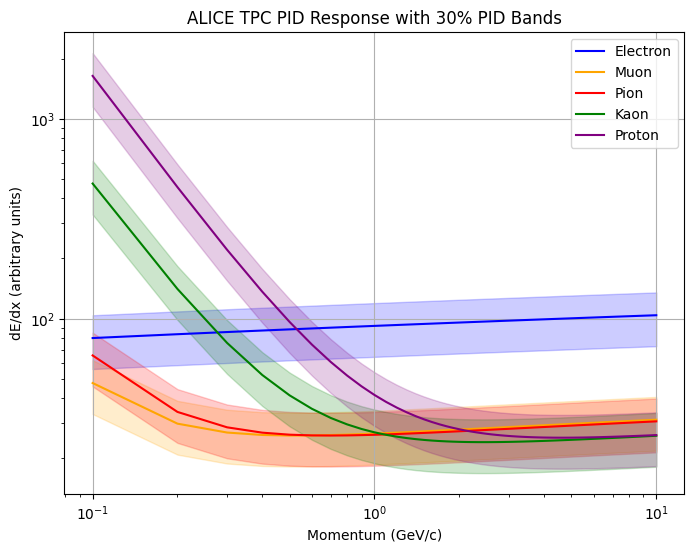

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def bethe_bloch(momentum, mass, charge=1):
    """
    Parametrizes the Bethe-Bloch formula for energy loss in the TPC.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - mass: Particle mass (GeV/c^2)
    - charge: Particle charge (default = 1)
    
    Returns:
    - dE/dx: Energy loss per unit distance (arbitrary units)
    """
    # Constants for Bethe-Bloch approximation
    K = 0.307075  # MeV mol^-1 cm^2
    Z = charge  # Particle charge
    I = 0.000016  # Mean excitation potential (MeV)
    m_e = 0.511  # Electron mass in MeV/c^2
    rho = 1  # Density of the material (relative to water, for simplicity)

    # Relativistic terms
    beta = momentum / np.sqrt(momentum**2 + mass**2)
    gamma = 1 / np.sqrt(1 - beta**2)
    
    # Bethe-Bloch equation (simplified)
    dEdx = ((K * Z**2 * rho) / (beta**2) * (0.5 * np.log(2 * m_e * beta**2 * gamma**2 / I**2) - beta**2)) * 17
    
    return dEdx

def tpc_pid_response(momentum, particle_type, stretch_factor=1):
    """
    Provides a parametrized TPC PID response for different particle types with a 30% PID band.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - particle_type: Type of particle ('electron', 'muon', 'pion', 'kaon', 'proton')
    
    Returns:
    - dE/dx: TPC PID response (arbitrary units)
    - lower_band: Lower bound of PID band (70% of dE/dx)
    - upper_band: Upper bound of PID band (130% of dE/dx)
    """
    mass_dict = {
        'electron': 0.000511,
        'muon': 0.10566,
        'pion': 0.13957,
        'kaon': 0.49367,
        'proton': 0.93827
    }
    
    mass = mass_dict.get(particle_type, 0.13957)  # Default to pion mass if not found
    dEdx = bethe_bloch(momentum, mass) * stretch_factor
    lower_band = dEdx * 0.7
    upper_band = dEdx * 1.3
    
    return dEdx, lower_band, upper_band

def error_extremes(momentum, particle_type, stretch_factor):
    """
    Helper function to return error band extremes for a given particle type.
    """
    _, lower_band, upper_band = tpc_pid_response(momentum, particle_type, stretch_factor)
    return upper_band, lower_band

def plot_tpc_pid_response(momentum_range):
    """
    Plot the TPC PID response and error bands for various particle types.
    """
    # Calculate responses and PID bands for different particle species
    particle_types = {
        'Electron': {'color': 'blue', 'stretch_factor': 1},
        'Muon': {'color': 'orange', 'stretch_factor': 0.41},
        'Pion': {'color': 'red', 'stretch_factor': 0.41},
        'Kaon': {'color': 'green', 'stretch_factor': 0.38},
        'Proton': {'color': 'purple', 'stretch_factor': 0.4}
    }
    
    plt.figure(figsize=(8, 6))
    
    for particle, settings in particle_types.items():
        response, lower_band, upper_band = tpc_pid_response(momentum_range, particle.lower(), settings['stretch_factor'])
        plt.plot(momentum_range, response, label=particle, color=settings['color'])
        plt.fill_between(momentum_range, lower_band, upper_band, color=settings['color'], alpha=0.2)
    
    plt.xlabel('Momentum (GeV/c)')
    plt.ylabel('dE/dx (arbitrary units)')
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.title('ALICE TPC PID Response with 30% PID Bands')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate a momentum range and plot
momentum_range = np.linspace(0.1, 10, 100)  # Momentum range from 0.1 to 10 GeV/c
plot_tpc_pid_response(momentum_range)


In [3]:
# Example usage
momentum_value = 1  # Example momentum value in GeV/c

# Get error band extremes for different particles
for particle in ['electron', 'proton', 'muon', 'pion', 'kaon']:
    max_band, min_band = error_extremes(momentum_value, particle, stretch_factor=1)
    print(f"At momentum {momentum_value} GeV/c for {particle.capitalize()}:")
    print(f"Maximum of error band: {max_band:.4f}")
    print(f"Minimum of error band: {min_band:.4f}")


At momentum 1 GeV/c for Electron:
Maximum of error band: 119.6635
Minimum of error band: 64.4342
At momentum 1 GeV/c for Proton:
Maximum of error band: 135.0813
Minimum of error band: 72.7361
At momentum 1 GeV/c for Muon:
Maximum of error band: 84.4890
Minimum of error band: 45.4941
At momentum 1 GeV/c for Pion:
Maximum of error band: 83.3139
Minimum of error band: 44.8613
At momentum 1 GeV/c for Kaon:
Maximum of error band: 92.4685
Minimum of error band: 49.7907


In [4]:
def calculate_nsigma(momentum, dEdx_observed, stretch_factors=None, error_fraction=0.3):
    """
    Calculates the nSigma value for each particle type based on observed dE/dx.
    
    Parameters:
    - momentum: Particle momentum (GeV/c)
    - dEdx_observed: Observed dE/dx value (arbitrary units)
    - stretch_factors: Dictionary of stretch factors for each particle type (default is 1.0 for all)
    - error_fraction: Fraction of error to use for standard deviation (default 0.3 or 30%)
    
    Returns:
    - nsigma_dict: Dictionary containing nSigma values for each particle type
    """
    if stretch_factors is None:
        stretch_factors = {
            'electron': 1.0,
            'muon': 1.0,
            'pion': 1.0,
            'kaon': 1.0,
            'proton': 1.0
        }
    
    particle_types = ['electron', 'muon', 'pion', 'kaon', 'proton']
    nsigma_dict = {}

    for particle in particle_types:
        stretch_factor = stretch_factors.get(particle, 1.0)
        dEdx_expected, _, _ = tpc_pid_response(momentum, particle, stretch_factor)
        sigma = dEdx_expected * error_fraction  # Standard deviation as a fraction of the expected dE/dx
        nsigma = (dEdx_observed - dEdx_expected) / sigma
        nsigma_dict[particle] = nsigma
    
    return nsigma_dict

# Example usage to calculate nSigma values
momentum_value1 = 4  # Example momentum in GeV/c
dEdx_observed = 100  # Example observed dE/dx value (arbitrary units)

# Define custom stretch factors
stretch_factors = {
    'electron': 1.0,
    'muon': .41,
    'pion': .41,
    'kaon': .38,
    'proton': .4
}

nsigma_values = calculate_nsigma(momentum_value1, dEdx_observed, stretch_factors)
print(f"nSigma values at momentum {momentum_value1} GeV/c and observed dE/dx {dEdx_observed}:")
for particle, nsigma in nsigma_values.items():
    print(f"{particle}: {nsigma:.2f}")

nSigma values at momentum 4 GeV/c and observed dE/dx 100:
electron: 0.02
muon: 8.04
pion: 8.27
kaon: 10.28
proton: 9.76
